# Hiragana Classification V2

## Data Wrangling

### Extraction and Clearning

In [1]:
import numpy as np
import os
import pandas as pd

def load_dataset():
    path_names = ['train-labels', 'train-imgs', 'test-labels', 'test-imgs']
    return np.load(os.path.join("datasets", 'hiragana.npz'))['arr_0']

In [2]:
dataset = load_dataset().reshape(-1, 127, 128)
dataset.shape

(11520, 127, 128)

From the specification, we know that there are 72 classes and exactly 160 instances correspond to a class.

In [3]:
import matplotlib.pyplot as plt

def plot_classes():
    f, axarr = plt.subplots(2,2)
    axarr[0, 0].imshow(dataset[0], cmap='binary')
    axarr[0, 1].imshow(dataset[48*160], cmap='binary')
    axarr[1, 0].imshow(dataset[49*160], cmap='binary')
    axarr[1, 1].imshow(dataset[71*160], cmap='binary')

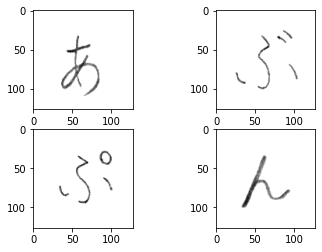

In [4]:
plot_classes()

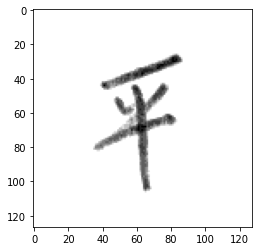

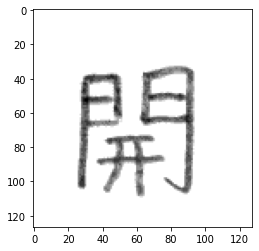

In [5]:
plt.imshow(dataset[6*160], cmap='binary')
plt.imshow(dataset[7*160 - 1], cmap='binary')
plt.show()
plt.imshow(dataset[65*160], cmap='binary')
plt.show()

In [53]:
plt.imshow(dataset[6*160].reshape(64,64), cmap='binary')

ValueError: cannot reshape array of size 16256 into shape (64,64)

It seems that this dataset has some data that is not in Hiragana form. In particular, classes 6, and 65 did not represent Hiragana character so I decide to remove these. In addition, the character を is misssing from this dataset.

In [6]:
# Removing unwanted data
to_remove = []
to_remove.extend(list(range(6*160, 7*160)))
to_remove.extend(list(range(65*160, 66*160)))
dataset = np.delete(dataset, to_remove, axis=0)
dataset.shape

(11200, 127, 128)

Now we have 70 classes and there is no y labels so I will just create it here.

In [116]:
y = []
for i in range(70):
    y.extend([i]*160)

y = np.array(y)
y.shape

(11200,)

### Resize and train-test split

For the sake of computation time, we will resize the image into 64x64.

In [117]:
from PIL import Image
def resize_X(X, size=(64,64)):
    n_instances = dataset.shape[0]
    width, height = dataset.shape[1:]
    
    new_X = np.zeros((n_instances, size[0], size[1]))
    for i in range(n_instances):
        image = Image.fromarray(dataset[i])
        new_X[i] = np.array(image.resize(size, Image.ANTIALIAS))
    
    return new_X

In [130]:
X = dataset/15.0
X = resize_X(X)
X.shape

(11200, 64, 64)

To train-test split, I will use sklearn api to split them. Stratified train-split would work well in this case.

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f'Ratio of a in trainset: {round((y_train==0).mean(), 4)}')
print(f'Ratio of a in testset{round((y_test==0).mean(), 4)}')

Ratio of a in trainset: 0.0143
Ratio of a in testset0.0143


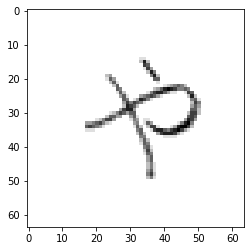

60

In [132]:
plt.imshow(X_train[41], cmap='binary')
plt.show()
y_train[41]

## Building Models
The performance measure I will use for models is accuracy.

#### Set up and configs

In [17]:
def calculate_accuracy(actual, predicted):
    return (actual== y_hats).mean()

In [18]:
def show_score(scores):
    print(f'CV Accuracy Mean: {scores.mean()}')
    print(f'std: {scores.std()}' )

In [84]:
width, height = 64,64
n_classes = 70

### RandomForest
- No fine-tuning in particular. Just a vanila RF.

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train.reshape(-1, width * height), y_train)

RandomForestClassifier()

In [21]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_clf, X_train.reshape(-1, width * height), y_train, scoring="accuracy", cv=10)
show_score(scores)

CV Accuracy Mean: 0.5683673469387756
std: 0.01391651193569985


In [22]:
y_hats = rf_clf.predict(X_test.reshape(-1, width * height))
print(f'test accuracy: {calculate_accuracy(y_test, y_hats)}')

test accuracy: 0.5681547619047619


### XGBoost
- same goes with XGboost

In [23]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(tree_method='gpu_hist')
xgb_clf.fit(X_train.reshape(-1, width * height), y_train)

/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:01:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [27]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_clf, X_train.reshape(-1, width * height), y_train, scoring="accuracy", cv=10)
show_score(scores)

/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:07:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:12:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:18:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:23:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:29:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:34:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:40:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:46:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:52:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/fuki-dev/windows/Project/hiragana-recogniser/venv/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:58:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV Accuracy Mean: 0.5668367346938775
std: 0.011382811998634251


In [28]:
y_hats = xgb_clf.predict(X_test.reshape(-1, width * height))
print(f'test accuracy: {calculate_accuracy(y_test, y_hats)}')

test accuracy: 0.5711309523809524


Both models don't perform well and seem to underfit the data. We will try more advanced models like CNN.

### Sequential #1
- A sequential nnet with a simple architecture. 
- Output activiation is softmax as this is a multi-label classification whose labels are exclusive. 
- ReLU is a nice default hidden activation function. 
- We will use cross entropy as loss function and stochastic gradient descent as optimizer as a starting point.

In [123]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

def build_seq_one():
    model = Sequential()
    model.add(Flatten(input_shape=[width, height]))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    return model

In [124]:
model1 = build_seq_one()
model1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               2097664   
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_35 (Dense)             (None, 70)                9030      
Total params: 2,270,918
Trainable params: 2,270,918
Non-trainable params: 0
_________________________________________________________________


In [125]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import sparse_categorical_crossentropy
model1.compile(loss=sparse_categorical_crossentropy,
             optimizer= SGD(learning_rate=0.00001),
             metrics=["accuracy"])

In [126]:
history = model1.fit(X_train, y_train, epochs=400, validation_split=0.2)

Epoch 1/400
196/196 [==============================] - 1s 5ms/step - loss: 4.2500 - accuracy: 0.0150 - val_loss: 4.2487 - val_accuracy: 0.0204
Epoch 2/400
196/196 [==============================] - 1s 5ms/step - loss: 4.2500 - accuracy: 0.0150 - val_loss: 4.2487 - val_accuracy: 0.0204
Epoch 3/400
196/196 [==============================] - 1s 5ms/step - loss: 4.2500 - accuracy: 0.0150 - val_loss: 4.2487 - val_accuracy: 0.0204
Epoch 4/400
196/196 [==============================] - 1s 5ms/step - loss: 4.2500 - accuracy: 0.0150 - val_loss: 4.2487 - val_accuracy: 0.0204
Epoch 5/400
196/196 [==============================] - 1s 5ms/step - loss: 4.2500 - accuracy: 0.0150 - val_loss: 4.2487 - val_accuracy: 0.0204
Epoch 6/400
196/196 [==============================] - 1s 4ms/step - loss: 4.2500 - accuracy: 0.0150 - val_loss: 4.2487 - val_accuracy: 0.0204
Epoch 7/400
196/196 [==============================] - 1s 5ms/step - loss: 4.2499 - accuracy: 0.0150 - val_loss: 4.2487 - val_accuracy: 0.0204

KeyboardInterrupt: 

<AxesSubplot:>

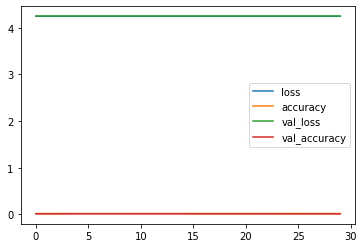

In [36]:
pd.DataFrame(history.history).plot()

In [37]:
model1.evaluate(X_test, y_test)

105/105 [==============================] - 0s 2ms/step - loss: 4.2483 - accuracy: 0.0179


[4.248263835906982, 0.01785714365541935]

The simple sequential model seems to suffer from overfitting. It doesn't generalise well and performs even worse than random forest or xgboost. It might not be good idea to proceed with this model.

### CNN #1
- Building a simple CNN with SGD with momentum as a optimizer

In [133]:
from keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import initializers

def build_cnn_one():
    model = Sequential()
    model.add(Conv2D(32,kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     kernel_size=(3,3),
                    activation="relu",
                    input_shape=[width, height, 1]))
    model.add(Conv2D(64, (3,3), activation="relu",kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    
    return model

In [134]:
model = build_cnn_one()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 57600)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               14745856  
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)             

In [135]:
model.compile(loss=sparse_categorical_crossentropy,
             optimizer=SGD(learning_rate=0.001, momentum=0.9, nesterov=True),
             metrics=['accuracy'])

In [136]:
model.fit(X_train.reshape(X_train.shape[0], width, height, 1), y_train, epochs=20, validation_split=0.2)

Epoch 1/20
196/196 [==============================] - 29s 146ms/step - loss: 4.2475 - accuracy: 0.0136 - val_loss: 4.2433 - val_accuracy: 0.0204
Epoch 2/20
196/196 [==============================] - 29s 147ms/step - loss: 4.0804 - accuracy: 0.0510 - val_loss: 3.1382 - val_accuracy: 0.3087
Epoch 3/20
196/196 [==============================] - 29s 148ms/step - loss: 2.9168 - accuracy: 0.2841 - val_loss: 2.0403 - val_accuracy: 0.5249
Epoch 4/20
196/196 [==============================] - 29s 147ms/step - loss: 2.2240 - accuracy: 0.4290 - val_loss: 1.7093 - val_accuracy: 0.5944
Epoch 5/20
196/196 [==============================] - 29s 147ms/step - loss: 1.8463 - accuracy: 0.5118 - val_loss: 1.4746 - val_accuracy: 0.6244
Epoch 6/20
196/196 [==============================] - 29s 150ms/step - loss: 1.6325 - accuracy: 0.5703 - val_loss: 1.3220 - val_accuracy: 0.6594
Epoch 7/20
196/196 [==============================] - 30s 153ms/step - loss: 1.4475 - accuracy: 0.6054 - val_loss: 1.2505 - val_ac

<AxesSubplot:>

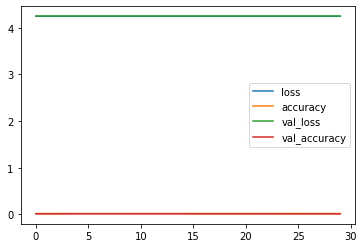

In [137]:
pd.DataFrame(history.history).plot() 

In [138]:
model.evaluate(X_test.reshape(X_test.shape[0], width, height, 1), y_test)

105/105 [==============================] - 2s 23ms/step - loss: 0.8371 - accuracy: 0.7723


[0.8371384143829346, 0.7723214030265808]

Pretty good performnce for its simplicity.

### CNN #2 - Deeper 
- Trying to build deeper network than CNN #1
- Also changed optimiser to Adam

In [144]:
def build_cnn_two():
    model = Sequential([
        Conv2D(64, 7, activation='relu', padding='same', input_shape=[width, height,1]),
        MaxPooling2D(2),
        Conv2D(128, 3, activation='relu', padding='same'),
        Conv2D(128, 3, activation='relu', padding='same'),
        MaxPooling2D(2),
        Conv2D(256, 3, activation='relu', padding='same'),
        Conv2D(256, 3, activation='relu', padding='same'),
        MaxPooling2D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    
    return model
    
model = build_cnn_two()

In [145]:
from tensorflow.keras.optimizers import Adam

model.compile(loss=sparse_categorical_crossentropy,
             optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
             metrics=['accuracy'])

In [146]:
model.fit(X_train.reshape(X_train.shape[0], width, height,1), y_train, epochs=10, validation_split=0.2)

Epoch 1/10
196/196 [==============================] - 77s 389ms/step - loss: 4.1486 - accuracy: 0.0317 - val_loss: 3.6217 - val_accuracy: 0.1779
Epoch 2/10
196/196 [==============================] - 79s 405ms/step - loss: 3.3511 - accuracy: 0.1515 - val_loss: 2.3333 - val_accuracy: 0.5172
Epoch 3/10
196/196 [==============================] - 80s 406ms/step - loss: 2.5751 - accuracy: 0.2835 - val_loss: 1.3798 - val_accuracy: 0.7117
Epoch 4/10
196/196 [==============================] - 81s 414ms/step - loss: 2.1066 - accuracy: 0.3686 - val_loss: 1.0222 - val_accuracy: 0.7526
Epoch 5/10
196/196 [==============================] - 77s 395ms/step - loss: 1.7468 - accuracy: 0.4644 - val_loss: 0.7859 - val_accuracy: 0.8246
Epoch 6/10
196/196 [==============================] - 81s 412ms/step - loss: 1.5620 - accuracy: 0.5053 - val_loss: 0.6327 - val_accuracy: 0.8763
Epoch 7/10
196/196 [==============================] - 78s 400ms/step - loss: 1.3706 - accuracy: 0.5627 - val_loss: 0.4981 - val_ac

In [147]:
model.evaluate(X_test.reshape(X_test.shape[0], width, height,1), y_test)

105/105 [==============================] - 9s 83ms/step - loss: 0.2460 - accuracy: 0.9354


[0.24604137241840363, 0.9354166388511658]

In [148]:
model.save(os.path.join('models', 'final_model'))

2021-10-12 07:30:42.948632: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/final_model/assets


## Future work

- The character を is missing. I only have 28x28 images so I cannot merge this data into here.
- Further fine-tune the model

I will leave it for now but I will come back to experiment further.